# Clear Pycache

In [1]:
import shutil
import os


directory_list = ['', "Data", "Models", "Training", "Notebooks", "Visualizer", "Models/DeepLabV3_Plus"]
for directory in directory_list:
    directory = os.path.join("..", directory, "__pycache__")
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Removed {directory}")

Removed ..\Data\__pycache__
Removed ..\Models\__pycache__
Removed ..\Training\__pycache__
Removed ..\Models/DeepLabV3_Plus\__pycache__


# Imports

In [2]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import numpy as np
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import ImageShow, Image
import matplotlib.pyplot as plt

from Models import UNet, DeepLabV3_Plus
from Data.dataset import UnetDataSet
from Data.dataloader import get_loaders
from Data.transforms import get_train_transforms, get_val_transforms
from Config.config_deeplab_v3_plus import IMAGE_SIZE

from Training.checkpoint import load_checkpoint, save_checkpoint, save_checkpoint

# Cityscapes class Labels

In [1]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
import numpy as np

id2color = {label.id: np.asarray(label.color) for label in labels}

def decode_mask(encoded_mask):
    encoded_mask = np.array(encoded_mask)
    shape = encoded_mask.shape + (3,)
    decoded_mask = np.zeros(shape, dtype='uint8')

    for label_id, color in id2color.items():
        decoded_mask[encoded_mask == label_id] = color

    return decoded_mask

# Hyperparameters

In [4]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 200
NUM_WORKERS = 4
IMAGE_HEIGHT, IMAGE_WIDTH = IMAGE_SIZE
MAX_BATCH = None
PIN_MEMORY = True
LOAD_MODEL = True
NUM_CLASSES = 35

# Dataset Directories

## Carvana

In [5]:
TRAIN_IMG_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/train_images'
TRAIN_MASK_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/train_encoded_masks'
VAL_IMG_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/val_images'
VAL_MASK_DIR = 'F:/UNI_STUFF/Thesis/cityscapes_data/val_encoded_masks'
CHECKPOINT_FIlE = "../Checkpoints/cityscapes_checkpoint_DeepLabV3_Plus.pth"

## Self Driving Cars

image_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

dataset = UnetDataSet(image_dir, mask_dir, transform=
                            A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
    ]
))


img, mask = dataset[0]

mask = np.longlong(mask)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(mask)
plt.show()

# Load Model

In [6]:
model = DeepLabV3_Plus(NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=4e-3)
# optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE, weight_decay=4e-3, momentum=0.9)
start_epoch = 0

try:
    if LOAD_MODEL:
        start_epoch = load_checkpoint(ckpt_file=CHECKPOINT_FIlE, model=model, optimizer=optimizer)
except Exception as e:
    print(f"Error loading checkpoint: {str(e)}")
    start_epoch = 0

train_ds = UnetDataSet(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=get_train_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))
val_ds = UnetDataSet(VAL_IMG_DIR, VAL_MASK_DIR, transform=get_val_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))

train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

=> Loading checkpoint


# Training Loop

Starting from epoch 28


Epoch 28: 100%|██████████| 744/744 [09:01<00:00,  1.38batch/s, Loss=0.529, Pixel Accuracy=0.852, mIoU=0.223]


0.4899110769632683
=> Epoch 28 is complete
=> Saving checkpoint


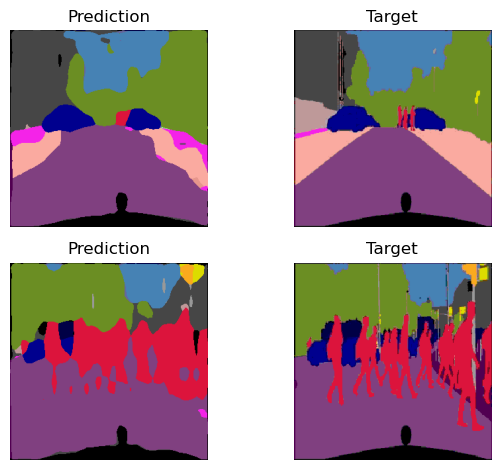

Epoch 29: 100%|██████████| 744/744 [09:09<00:00,  1.35batch/s, Loss=0.639, Pixel Accuracy=0.811, mIoU=0.212]


0.4880842062574561
=> Epoch 29 is complete
=> Saving checkpoint


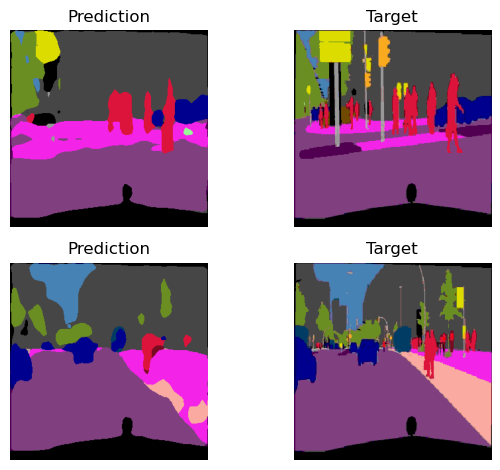

Epoch 30: 100%|██████████| 744/744 [09:07<00:00,  1.36batch/s, Loss=0.688, Pixel Accuracy=0.802, mIoU=0.197]


0.4817345206455518
=> Epoch 30 is complete
=> Saving checkpoint


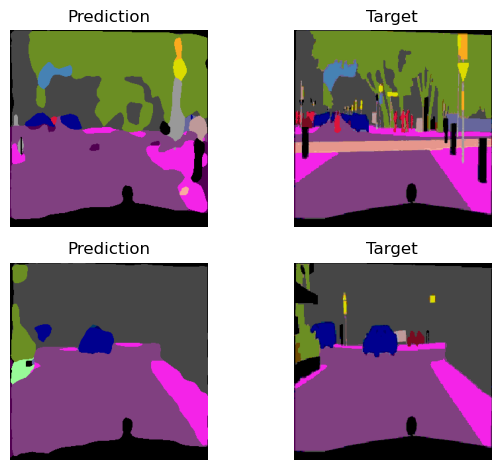

Epoch 31: 100%|██████████| 744/744 [09:06<00:00,  1.36batch/s, Loss=0.577, Pixel Accuracy=0.826, mIoU=0.209]


0.482225620097691
=> Epoch 31 is complete
=> Saving checkpoint


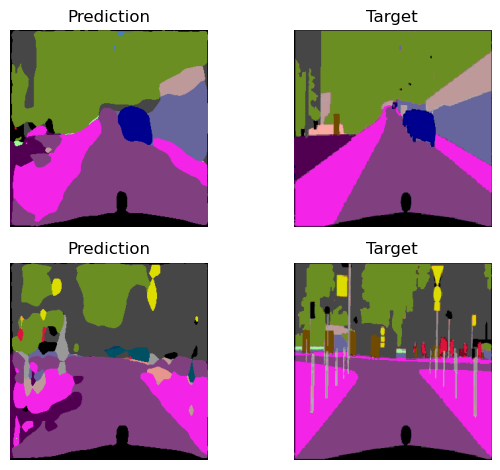

Epoch 32: 100%|██████████| 744/744 [09:08<00:00,  1.36batch/s, Loss=0.586, Pixel Accuracy=0.823, mIoU=0.201]


0.4808185857229976
=> Epoch 32 is complete
=> Saving checkpoint


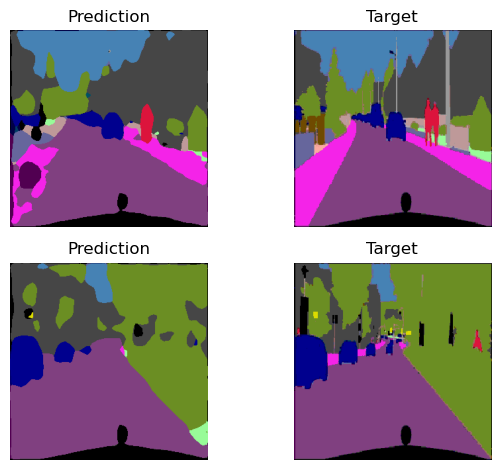

Epoch 33: 100%|██████████| 744/744 [09:13<00:00,  1.34batch/s, Loss=0.425, Pixel Accuracy=0.879, mIoU=0.211]


0.4769172876352264
=> Epoch 33 is complete
=> Saving checkpoint


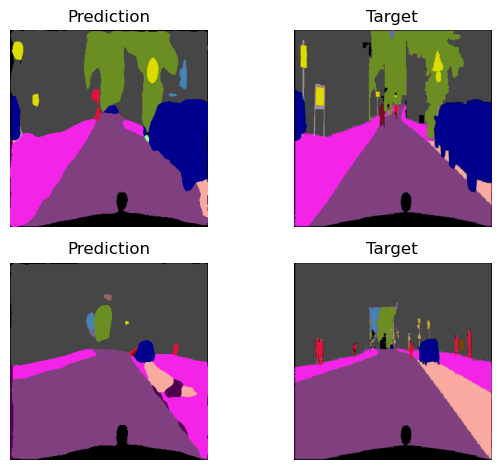

Epoch 34: 100%|██████████| 744/744 [09:12<00:00,  1.35batch/s, Loss=0.519, Pixel Accuracy=0.857, mIoU=0.197]


0.4727442955938719
=> Epoch 34 is complete
=> Saving checkpoint


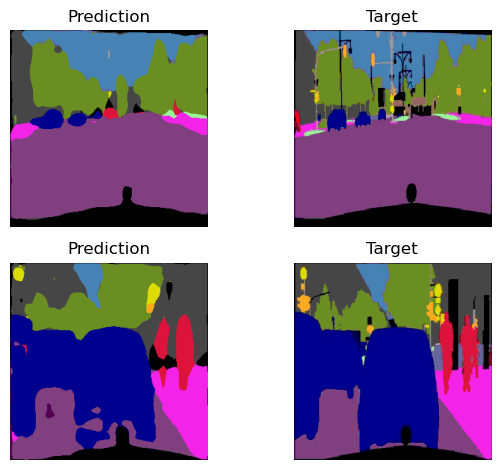

Epoch 35: 100%|██████████| 744/744 [09:10<00:00,  1.35batch/s, Loss=0.448, Pixel Accuracy=0.87, mIoU=0.185] 


0.47318004680577147
=> Epoch 35 is complete
=> Saving checkpoint


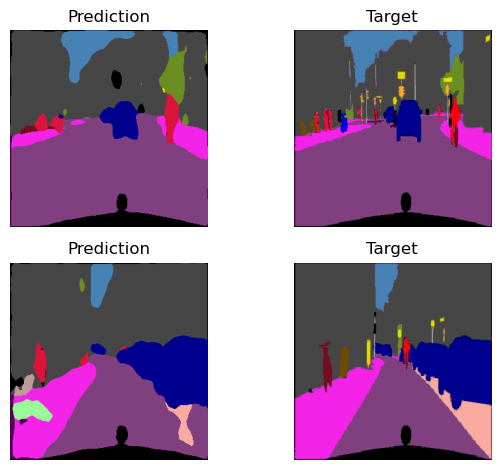

Epoch 36: 100%|██████████| 744/744 [09:10<00:00,  1.35batch/s, Loss=0.508, Pixel Accuracy=0.85, mIoU=0.217] 


0.4706609005168561
=> Epoch 36 is complete
=> Saving checkpoint


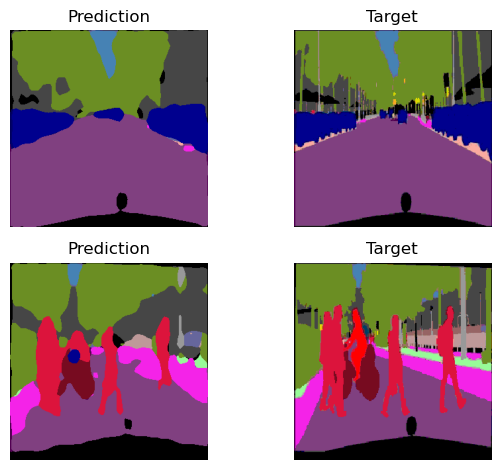

Epoch 37: 100%|██████████| 744/744 [09:13<00:00,  1.34batch/s, Loss=0.466, Pixel Accuracy=0.866, mIoU=0.204]


0.46928293894856205
=> Epoch 37 is complete
=> Saving checkpoint


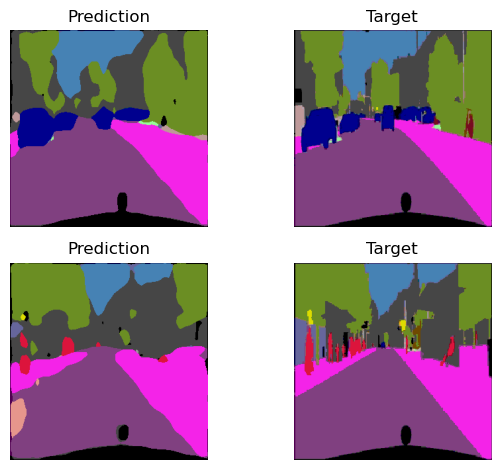

Epoch 38: 100%|██████████| 744/744 [09:14<00:00,  1.34batch/s, Loss=0.501, Pixel Accuracy=0.858, mIoU=0.193]


0.4667091906791733
=> Epoch 38 is complete
=> Saving checkpoint


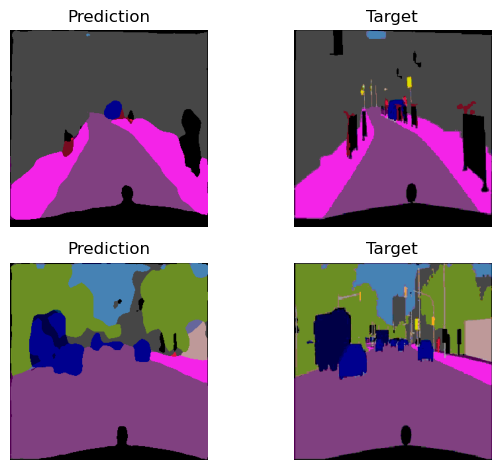

Epoch 39: 100%|██████████| 744/744 [09:14<00:00,  1.34batch/s, Loss=0.447, Pixel Accuracy=0.866, mIoU=0.228]


0.4647239880456078
=> Epoch 39 is complete
=> Saving checkpoint


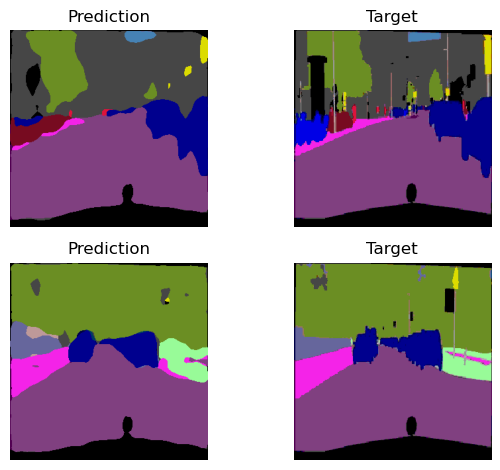

Epoch 40: 100%|██████████| 744/744 [09:14<00:00,  1.34batch/s, Loss=0.475, Pixel Accuracy=0.863, mIoU=0.195]


0.4651900094042542
=> Epoch 40 is complete
=> Saving checkpoint


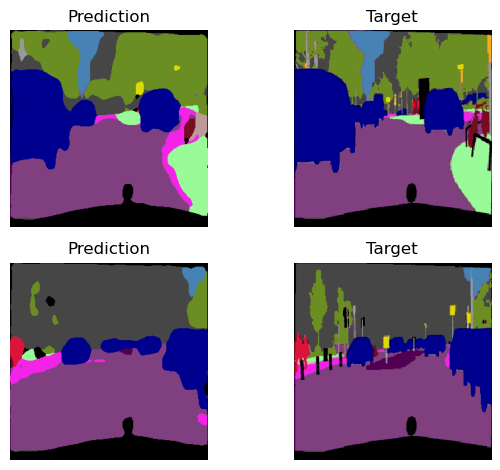

Epoch 41: 100%|██████████| 744/744 [09:13<00:00,  1.34batch/s, Loss=0.323, Pixel Accuracy=0.913, mIoU=0.212]


0.46265320531943793
=> Epoch 41 is complete
=> Saving checkpoint


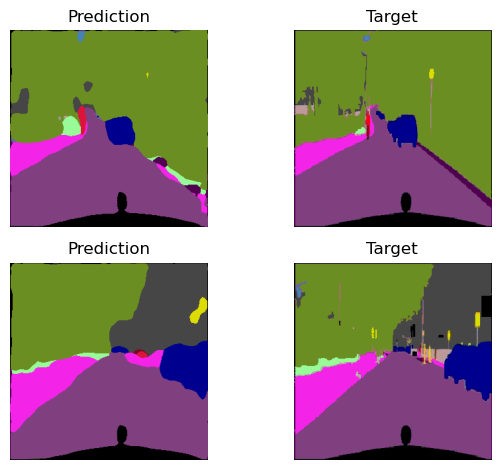

Epoch 42: 100%|██████████| 744/744 [09:13<00:00,  1.34batch/s, Loss=0.593, Pixel Accuracy=0.822, mIoU=0.174]


0.45668813438024575
=> Epoch 42 is complete
=> Saving checkpoint


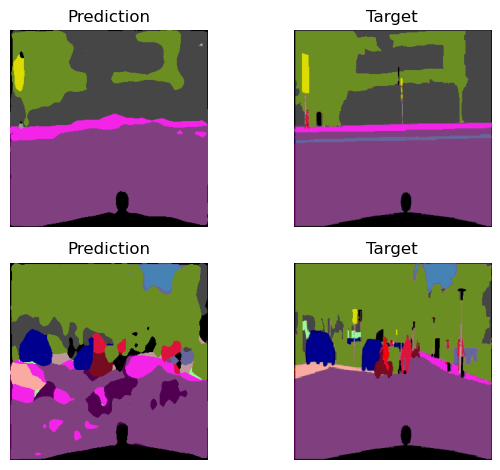

Epoch 43: 100%|██████████| 744/744 [09:17<00:00,  1.34batch/s, Loss=0.457, Pixel Accuracy=0.868, mIoU=0.223]


0.4607074843138777
=> Epoch 43 is complete
=> Saving checkpoint


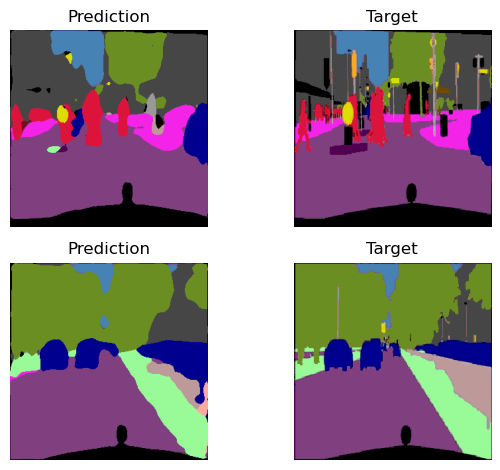

Epoch 44: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.445, Pixel Accuracy=0.868, mIoU=0.201]


0.4582444757463471
=> Epoch 44 is complete
=> Saving checkpoint


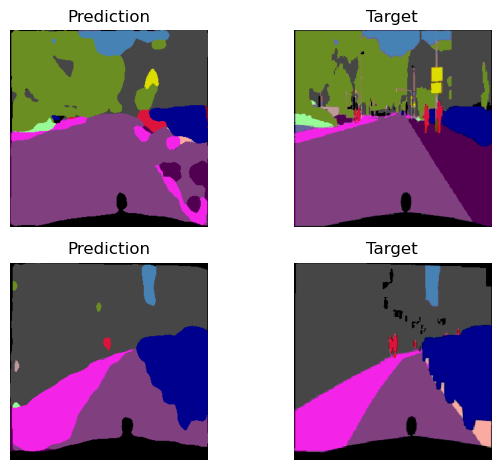

Epoch 45: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.484, Pixel Accuracy=0.858, mIoU=0.208]


0.45816320337114796
=> Epoch 45 is complete
=> Saving checkpoint


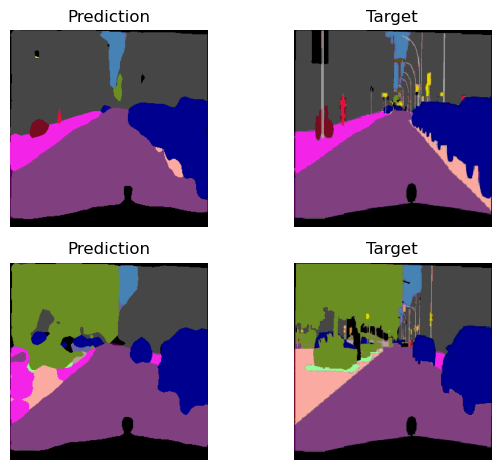

Epoch 46: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.413, Pixel Accuracy=0.878, mIoU=0.213]


0.45659878032822765
=> Epoch 46 is complete
=> Saving checkpoint


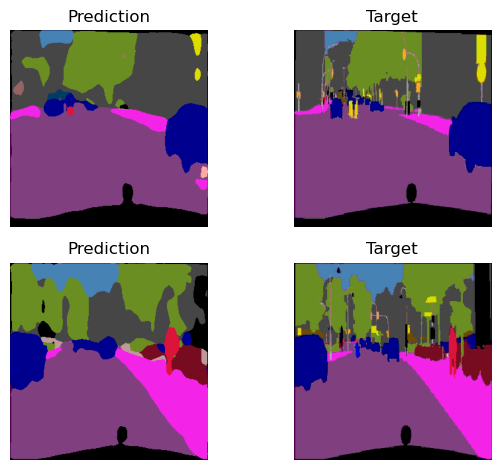

Epoch 47: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.407, Pixel Accuracy=0.881, mIoU=0.261]


0.4508601481155042
=> Epoch 47 is complete
=> Saving checkpoint


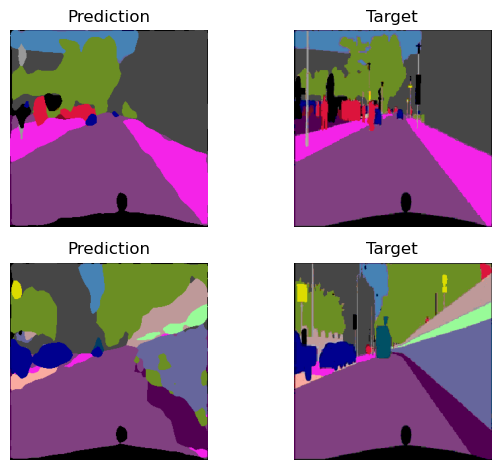

Epoch 48: 100%|██████████| 744/744 [09:14<00:00,  1.34batch/s, Loss=0.394, Pixel Accuracy=0.889, mIoU=0.208]


0.45336190755328826
=> Epoch 48 is complete
=> Saving checkpoint


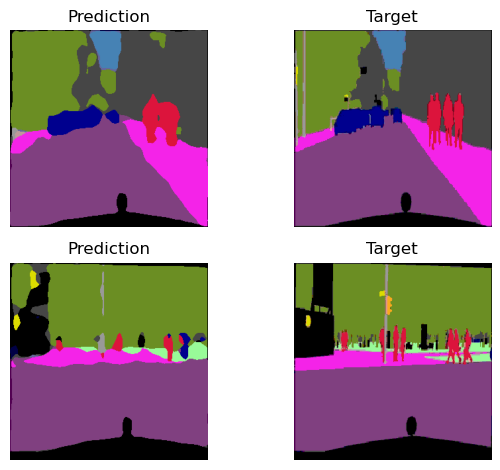

Epoch 49: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.399, Pixel Accuracy=0.885, mIoU=0.225]


0.45066262357017045
=> Epoch 49 is complete
=> Saving checkpoint


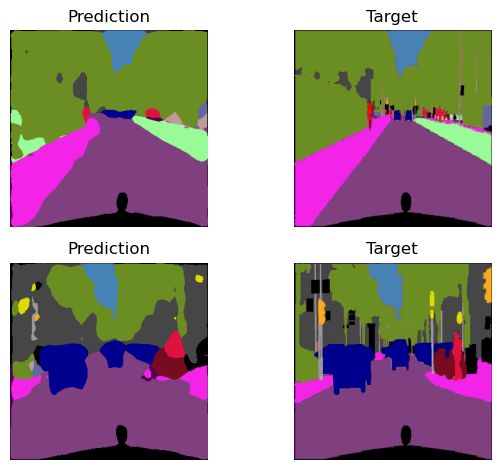

Epoch 50: 100%|██████████| 744/744 [09:16<00:00,  1.34batch/s, Loss=0.472, Pixel Accuracy=0.866, mIoU=0.231]


0.45123961395634116
=> Epoch 50 is complete
=> Saving checkpoint


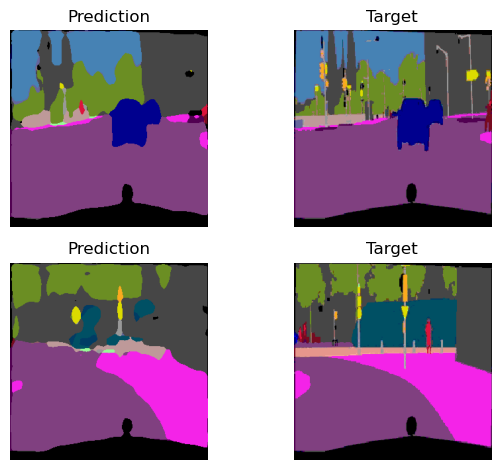

Epoch 51: 100%|██████████| 744/744 [09:18<00:00,  1.33batch/s, Loss=0.405, Pixel Accuracy=0.89, mIoU=0.233] 


0.4474811195846527
=> Epoch 51 is complete
=> Saving checkpoint


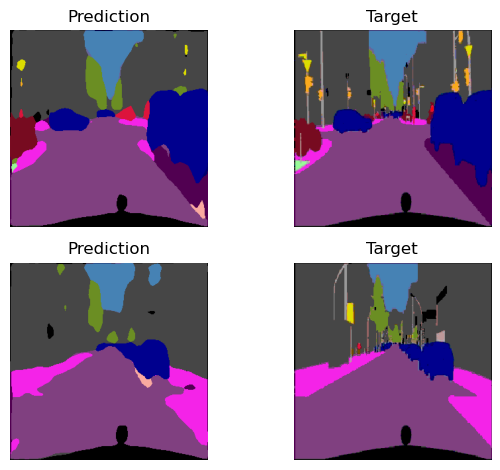

Epoch 52: 100%|██████████| 744/744 [09:25<00:00,  1.32batch/s, Loss=0.413, Pixel Accuracy=0.879, mIoU=0.184]


0.44828559302033916
=> Epoch 52 is complete
=> Saving checkpoint


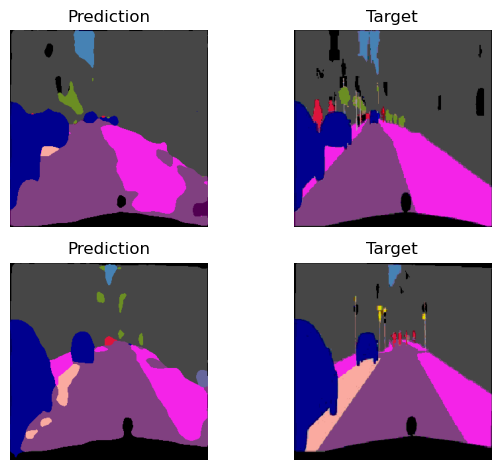

Epoch 53: 100%|██████████| 744/744 [09:20<00:00,  1.33batch/s, Loss=0.518, Pixel Accuracy=0.855, mIoU=0.213]


0.44438636947863847
=> Epoch 53 is complete
=> Saving checkpoint


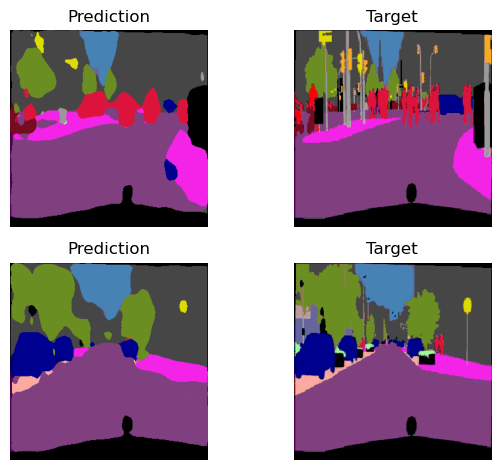

Epoch 54: 100%|██████████| 744/744 [09:22<00:00,  1.32batch/s, Loss=0.427, Pixel Accuracy=0.867, mIoU=0.222]


0.44775082255082743
=> Epoch 54 is complete
=> Saving checkpoint


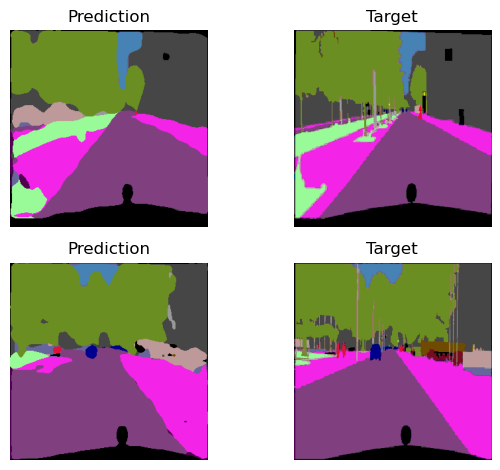

Epoch 55: 100%|██████████| 744/744 [09:21<00:00,  1.33batch/s, Loss=0.376, Pixel Accuracy=0.895, mIoU=0.219]


0.4427831423699215
=> Epoch 55 is complete
=> Saving checkpoint


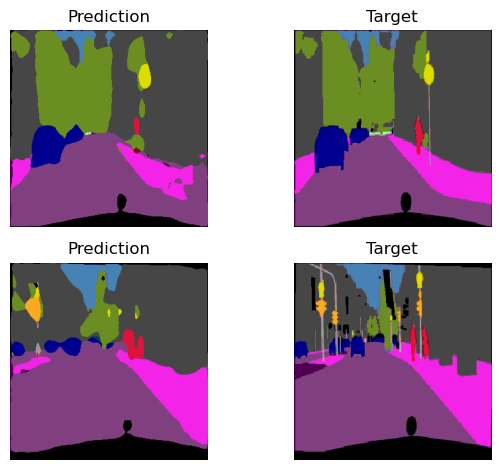

Epoch 56: 100%|██████████| 744/744 [09:22<00:00,  1.32batch/s, Loss=0.452, Pixel Accuracy=0.865, mIoU=0.236]


0.4472898627401039
=> Epoch 56 is complete
=> Saving checkpoint


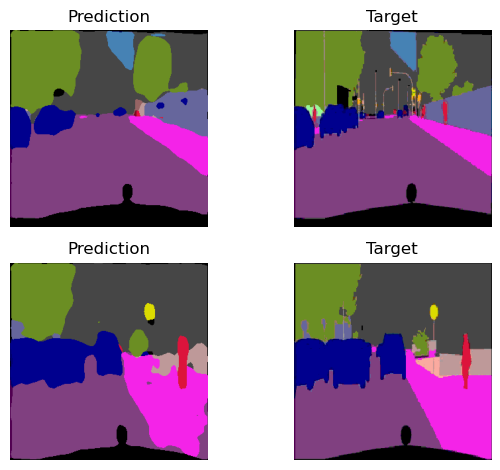

Epoch 57: 100%|██████████| 744/744 [09:27<00:00,  1.31batch/s, Loss=0.606, Pixel Accuracy=0.828, mIoU=0.237]


0.4391140821640209
=> Epoch 57 is complete
=> Saving checkpoint


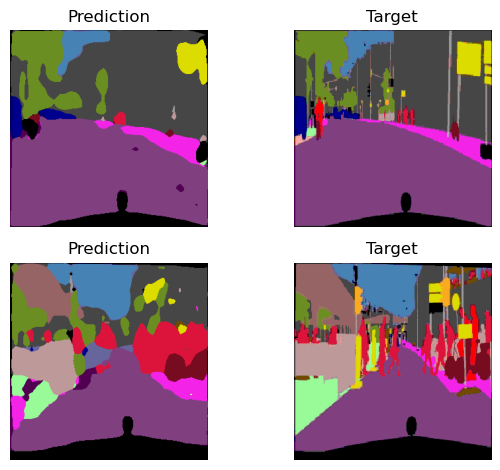

Epoch 58: 100%|██████████| 744/744 [09:22<00:00,  1.32batch/s, Loss=0.574, Pixel Accuracy=0.833, mIoU=0.198]


0.44376737628412505
=> Epoch 58 is complete
=> Saving checkpoint


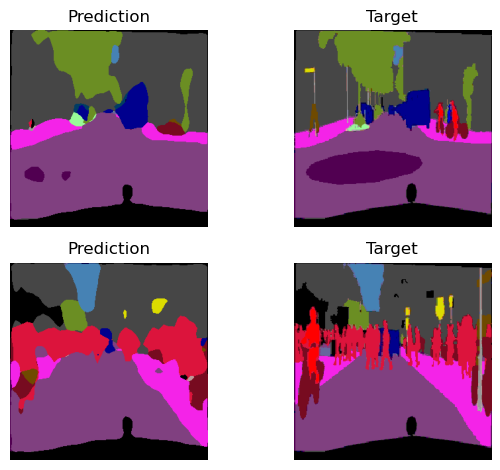

Epoch 59: 100%|██████████| 744/744 [09:21<00:00,  1.33batch/s, Loss=0.368, Pixel Accuracy=0.896, mIoU=0.216]


0.4425323661216485
=> Epoch 59 is complete
=> Saving checkpoint


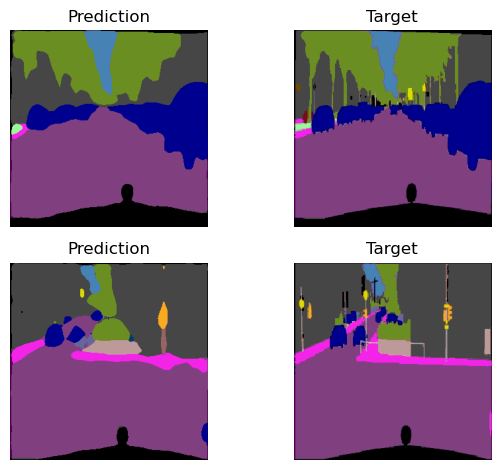

Epoch 60: 100%|██████████| 744/744 [09:21<00:00,  1.33batch/s, Loss=0.395, Pixel Accuracy=0.887, mIoU=0.198]


0.4430078978259717
=> Epoch 60 is complete
=> Saving checkpoint


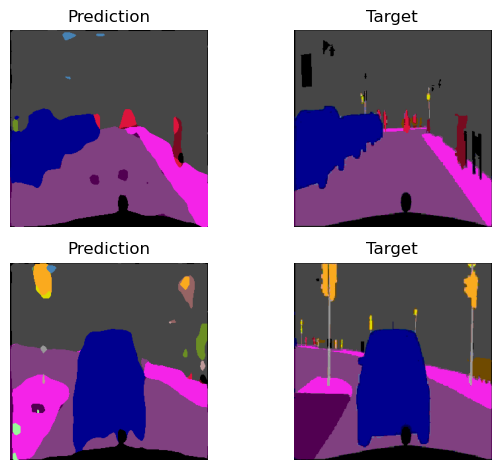

Epoch 61: 100%|██████████| 744/744 [09:23<00:00,  1.32batch/s, Loss=0.449, Pixel Accuracy=0.877, mIoU=0.229]


0.4387737877907292
=> Epoch 61 is complete
=> Saving checkpoint


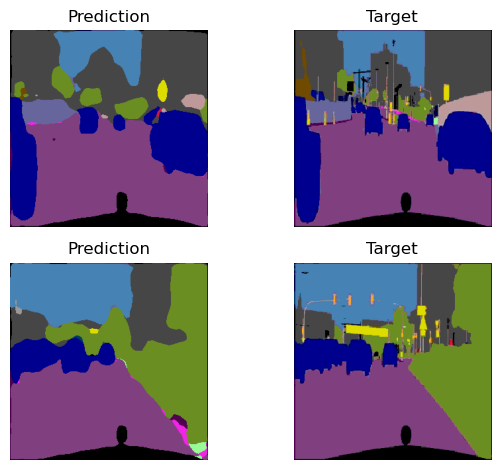

Epoch 62: 100%|██████████| 744/744 [09:19<00:00,  1.33batch/s, Loss=0.368, Pixel Accuracy=0.891, mIoU=0.228]


0.4365307793662112
=> Epoch 62 is complete
=> Saving checkpoint


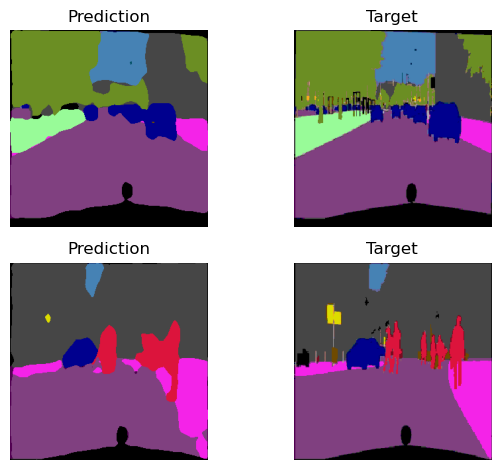

Epoch 63: 100%|██████████| 744/744 [09:18<00:00,  1.33batch/s, Loss=0.398, Pixel Accuracy=0.888, mIoU=0.206]


0.4403371679526503
=> Epoch 63 is complete
=> Saving checkpoint


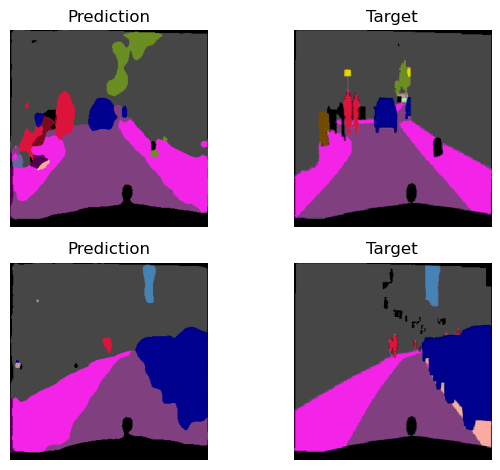

Epoch 64: 100%|██████████| 744/744 [09:18<00:00,  1.33batch/s, Loss=0.59, Pixel Accuracy=0.801, mIoU=0.209] 


0.438038056856522
=> Epoch 64 is complete
=> Saving checkpoint


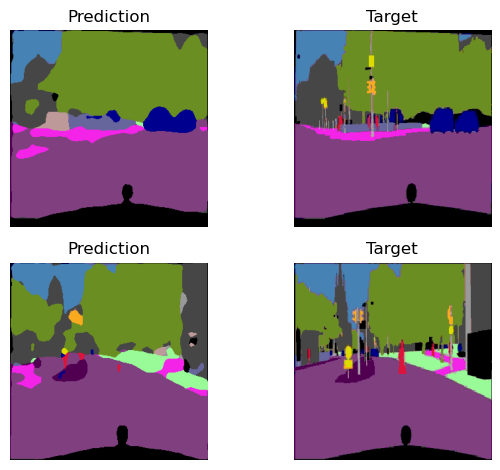

Epoch 65: 100%|██████████| 744/744 [09:18<00:00,  1.33batch/s, Loss=0.356, Pixel Accuracy=0.899, mIoU=0.24] 


0.4395773533771756
=> Epoch 65 is complete
=> Saving checkpoint


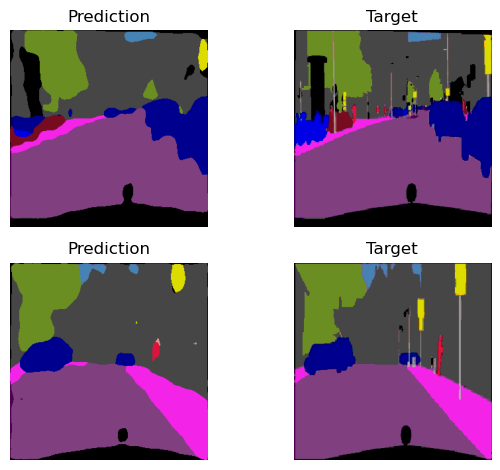

Epoch 66: 100%|██████████| 744/744 [09:19<00:00,  1.33batch/s, Loss=0.579, Pixel Accuracy=0.826, mIoU=0.215]


0.43482154351408764
=> Epoch 66 is complete
=> Saving checkpoint


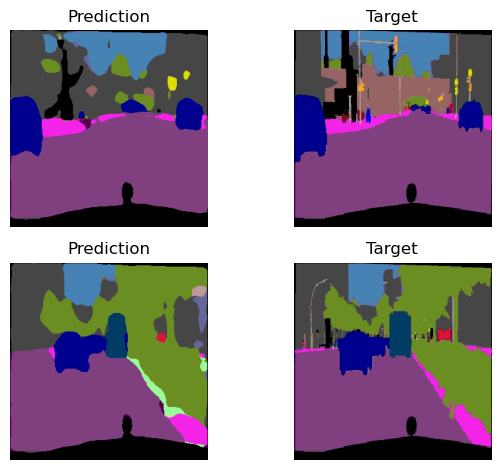

Epoch 67: 100%|██████████| 744/744 [09:18<00:00,  1.33batch/s, Loss=0.494, Pixel Accuracy=0.863, mIoU=0.242]


0.4357017286682642
=> Epoch 67 is complete
=> Saving checkpoint


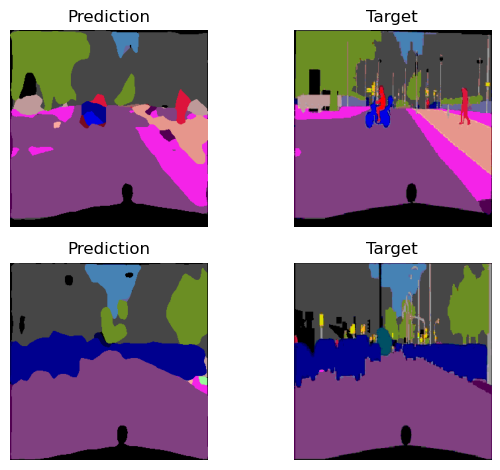

Epoch 68: 100%|██████████| 744/744 [09:17<00:00,  1.33batch/s, Loss=0.573, Pixel Accuracy=0.838, mIoU=0.237]


0.43469243592792944
=> Epoch 68 is complete
=> Saving checkpoint


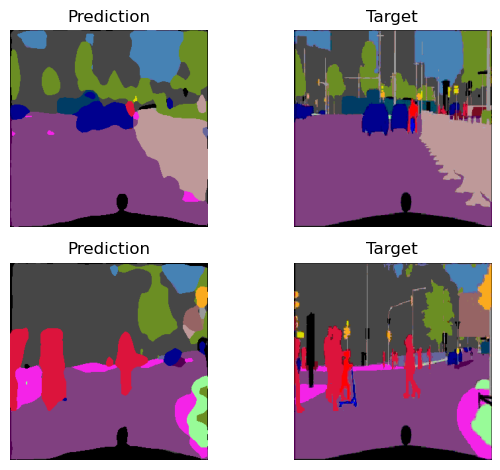

Epoch 69: 100%|██████████| 744/744 [09:19<00:00,  1.33batch/s, Loss=0.718, Pixel Accuracy=0.78, mIoU=0.236] 


0.43765896486659206
=> Epoch 69 is complete
=> Saving checkpoint


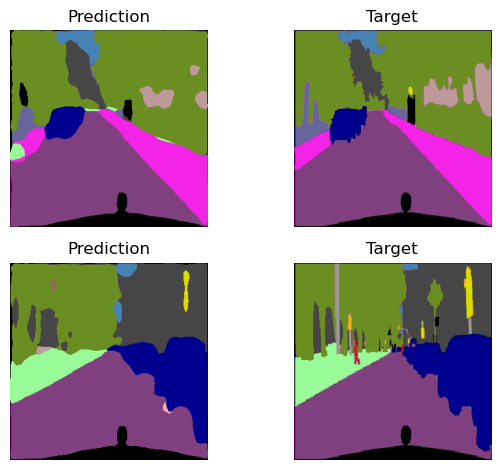

Epoch 70: 100%|██████████| 744/744 [09:31<00:00,  1.30batch/s, Loss=0.724, Pixel Accuracy=0.779, mIoU=0.21] 


0.4350131416032391
=> Epoch 70 is complete
=> Saving checkpoint


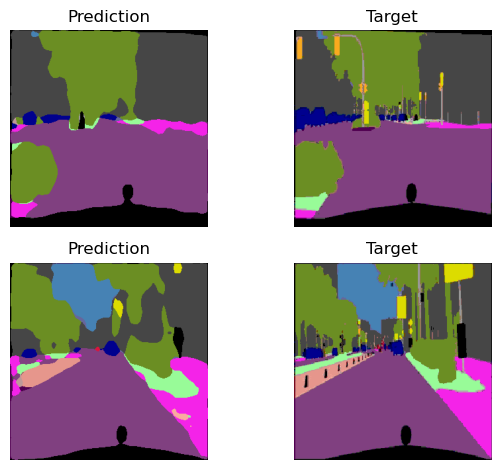

Epoch 71: 100%|██████████| 744/744 [09:31<00:00,  1.30batch/s, Loss=0.437, Pixel Accuracy=0.867, mIoU=0.236]


0.4349363831182321
=> Epoch 71 is complete
=> Saving checkpoint


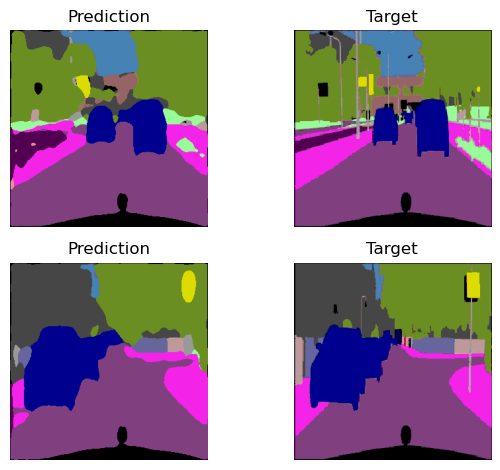

Epoch 72: 100%|██████████| 744/744 [09:28<00:00,  1.31batch/s, Loss=0.486, Pixel Accuracy=0.854, mIoU=0.222]


0.4345414771508145
=> Epoch 72 is complete
=> Saving checkpoint


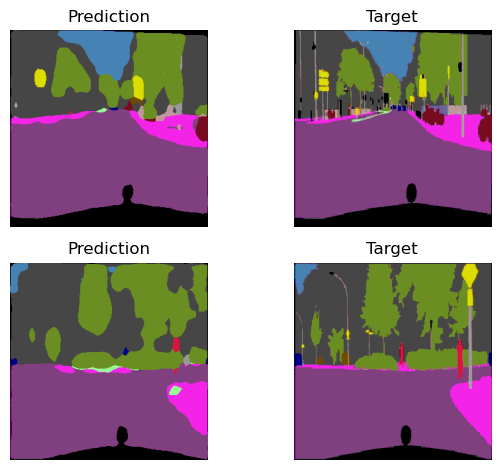

Epoch 73: 100%|██████████| 744/744 [09:32<00:00,  1.30batch/s, Loss=0.505, Pixel Accuracy=0.856, mIoU=0.2]  


0.43309487198149005
=> Epoch 73 is complete
=> Saving checkpoint


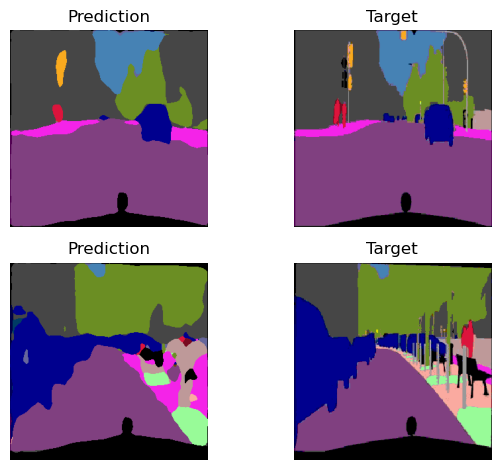

Epoch 74: 100%|██████████| 744/744 [09:28<00:00,  1.31batch/s, Loss=0.527, Pixel Accuracy=0.853, mIoU=0.227]


0.4333870380475957
=> Epoch 74 is complete
=> Saving checkpoint


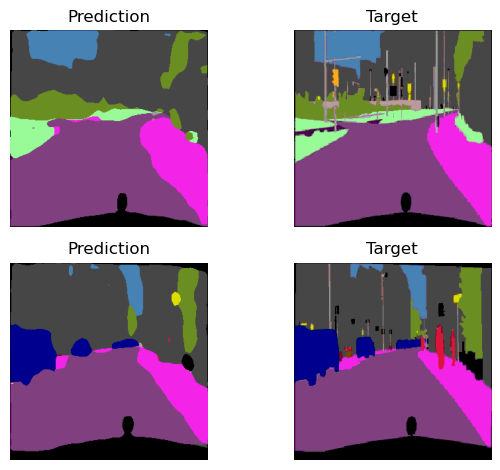

Epoch 75: 100%|██████████| 744/744 [09:16<00:00,  1.34batch/s, Loss=0.525, Pixel Accuracy=0.85, mIoU=0.206] 


0.43401330637355007
=> Epoch 75 is complete
=> Saving checkpoint


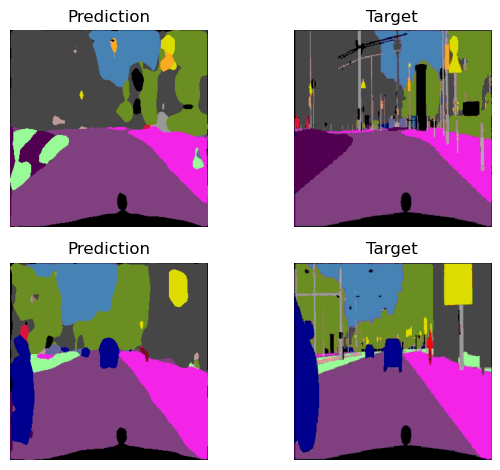

Epoch 76: 100%|██████████| 744/744 [09:15<00:00,  1.34batch/s, Loss=0.489, Pixel Accuracy=0.857, mIoU=0.206]


0.4323435282354714
=> Epoch 76 is complete
=> Saving checkpoint


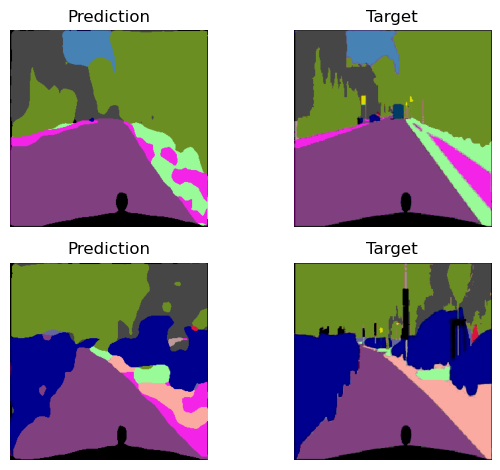

Epoch 77: 100%|██████████| 744/744 [09:14<00:00,  1.34batch/s, Loss=0.435, Pixel Accuracy=0.877, mIoU=0.206]


0.4308669509025671
=> Epoch 77 is complete
=> Saving checkpoint


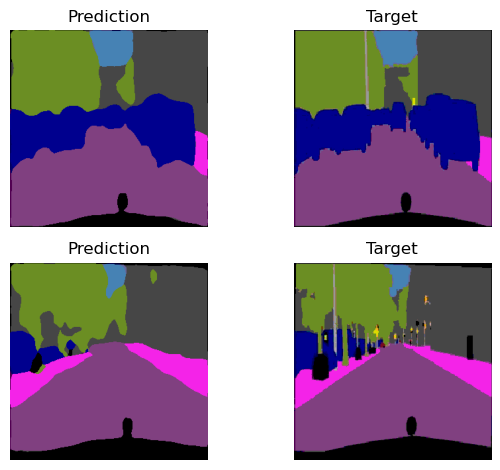

Epoch 78:  90%|█████████ | 671/744 [08:22<00:54,  1.33batch/s, Loss=0.421, Pixel Accuracy=0.879, mIoU=0.224]

In [7]:
from Training.history import History
from Training.trainer import train_fn

scaler = torch.cuda.amp.GradScaler()
history = History()
history.metrics = ["accuracy", "mIoU"]

start_epoch += 1 # start from the next epoch
print(f"Starting from epoch {start_epoch}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    predictions, masks, loss, score = train_fn(epoch, train_loader, model, optimizer, loss_fn, scaler, device=DEVICE)

    print(loss)
    history.train_losses.append(loss)
    history.train_scores["accuracy"].append(score["accuracy"])
    history.train_scores["mIoU"].append(score["mIoU"])

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "epoch": epoch,
    }
    print(f"=> Epoch {epoch} is complete")
    save_checkpoint(checkpoint, filename=CHECKPOINT_FIlE)

    #plot some examples to see how well the model is doing with matplotlib

    import matplotlib.pyplot as plt

    try:

        """Plotting the first prediction and target"""

        predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
        predictions = predictions.unsqueeze(1)
        masks = masks.unsqueeze(1)

        plt.subplot(2, 2, 1)
        plt.imshow(decode_mask(predictions[0][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(decode_mask(masks[0][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        # Plotting the second prediction and target
        plt.subplot(2, 2, 3)
        plt.imshow(decode_mask(predictions[1][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(decode_mask(masks[1][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")
        continue


# Test Prediction

In [2]:
import sys
sys.path.append('../')

import torch
from Models import UNet, DeepLabV3_Plus
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the model from the checkpoint
NUM_CLASSES = 35
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_FIlE = "../Checkpoints/cityscapes_checkpoint_DeepLabV3_Plus.pth"

model = DeepLabV3_Plus(n_classes=NUM_CLASSES)
checkpoint = torch.load(CHECKPOINT_FIlE)
model.load_state_dict(checkpoint["state_dict"])
# print(checkpoint["epoch"])
# model.eval()

transform = A.Compose([
    A.Resize(height=299, width=299),
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=1
    ),
    ToTensorV2()
])

# Load and preprocess the image
image_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_images/109.jpg"
mask_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_encoded_masks/109.jpg"

image = np.array(Image.open(image_dir).convert("RGB"))
image = transform(image=image)["image"]
image /= 255.0
# input_tensor = val_transforms(image=image)["image"].unsqueeze(0)

model = model.to(DEVICE)
image = image.unsqueeze(0).to(DEVICE)


# Make predictions

with torch.no_grad():
    predictions = model(image)

# Process the predictions as needed
# ...

# Print the predictions
predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
predictions = predictions.squeeze(0).cpu().numpy()



Decode the predictions to RGB

<Figure size 640x480 with 0 Axes>

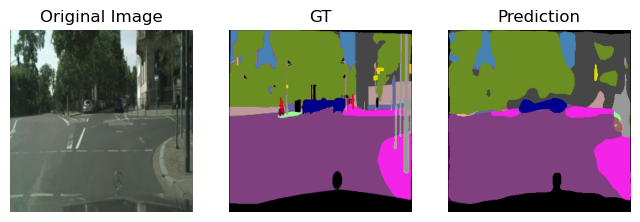

In [5]:
from Visualizer import plot_images

image_to_display = image.to('cpu')[0].permute(1, 2, 0).numpy()
masks = np.array(Image.open(mask_dir))
masks = decode_mask(masks)
prediction_to_display = decode_mask(predictions)

plot_images([image_to_display, masks, prediction_to_display], ['Original Image', 'GT', 'Prediction'], max_cols=3, figsize=(8, 4))
# plot_images([image_to_display, prediction_to_display], ['Original Image', 'Prediction'], max_cols=3, figsize=(4, 3))
